# Nonlinear Regression Using Linear Regression

Learning Objectives:
* Students will learn about how nonlinear regression can be achieved using linear regression.
* Students will visualize data in order to discern nonlinear relationships between variables.
* Students will engineer features that allow linear regression to build models for predicting variables that result from nonlinear relationships.
* Students will apply feature engineering to data in order to predict nonlinear relationships using such models.

Before class:
* Read [Will Koehrsen's "Visualizing Data with Pairs Plots in Python"](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)  _Medium.com, which includes the publication Towards Data Science, features a wealth of short articles on data science topics and is worth the monthly subscription.  Your first articles should be free._
* Jake VanderPlas.  [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook):
  * [5.4 - Feature Engineering subsection "Derived Features"](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.04-Feature-Engineering.ipynb) _Read only the "Derived Features" subsection._
* Read below up to (but not including) the section marked In Class.  **Perform listed tasks and supplemental reading as directed below.**

Optional how-to reference for plotting:
* Jake VanderPlas.  [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook):
  * [4.1 - Simple Line Plots](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.01-Simple-Line-Plots.ipynb)
  * [4.2 - Simple Scatter Plots](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.02-Simple-Scatter-Plots.ipynb)
  * [4.12 - Three-Dimensional Plotting in Matplotlib subsection "Three-dimensional Points and Lines"](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.12-Three-Dimensional-Plotting.ipynb) _Read only the "Three-dimensional Points and Lines subsection._
* Fabrizio Guerrieri's ["Use Python to plot Surface graphs of irregular Datasets"](https://fabrizioguerrieri.com/blog/surface-graphs-with-irregular-dataset/)

In class:
* We will work together on the exercises in section "In Class".

Homework after class:
* Complete the section labeled "Homework" below before the next class when it will be collected.


# Generating Example Data

In this section, I will demonstrate how one can generate the data we will use for illustrating techniques.  This section is _optional_ and is provided for those interested.  Eventually, we will cover Pandas in greater detail so that this will be comprehensible, but this necessary section creates the data we'll work with in most examples and exercises that follow.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from sklearn.linear_model import LinearRegression
import seaborn as sns

# We begin by importing our entire pseudorandom number generator (PRNG) module and giving it a "seed" for reproducability:
from random import *

# The PRNG is "pseudorandom" because the seemingly random number generation is actually a sort of "numeric blender" function that is deterministic,
# generates different sequences with high probability, and appears random in distribution and according to various statistical tests.
seed(0)
print(random())
print(random())

# The seed number creates the initial internal state of the PRNG, so starting with the same seed we get the same behavior:
print("Same seed, same PRNG behavior:")
seed(0)
print(random())
print(random())

# We'll next create a number of random coefficients that we'll use in our examples, filtered to make sure they are not too small in magnitude.
coeffs = list(filter(lambda x: abs(x) >= 1, map(lambda x: 40 * (random() - .5), 100 * [1])))

# Now we'll create the dataframes we'll use in most examples below.
np.random.seed(0)  # since we'll be using numpy's PRNG as well, we'll need to set its initial state with a seed too.

df1 = pd.DataFrame(np.random.uniform(low=-0.5, high=4.0, size=(20, 1)), columns=['x'])  # generate 20 random x values from -.5 to 4
c1 = sample(coeffs, 2)  # random selection of y intercept and coefficient from coeffs
m1 = lambda x: c1[0] + c1[1] * x
# generate y's from a linear function of x with Gaussian noise.
df1['y'] = df1['x'].map(lambda x: m1(x) + np.random.normal())

df2 = pd.DataFrame(np.random.uniform(low=-5, high=5, size=(100, 1)), columns=['x'])
c2 = sample(coeffs, 3)
m2 = lambda x: c2[0] + c2[1] * x + c2[2] * x * x
# generate y's from a nonlinear function of x with Gaussian noise.
df2['y'] = df2['x'].map(lambda x: m2(x) + np.random.normal(scale=10))

df3 = pd.DataFrame(np.random.uniform(low=-4, high=4, size=(100, 1)), columns=['x'])
c3 = sample(coeffs, 1)
m3 = lambda x: c3[0] ** x
df3['y'] = df3['x'].map(lambda x: abs(m3(x) + np.random.normal(scale=.01)))

df4 = pd.DataFrame(np.random.uniform(low=-5, high=5, size=(100, 1)), columns=['x'])
c4 = sample(coeffs, 4)
m4 = lambda x: c4[0] + c4[1] * x + c4[2] * x * x + c4[3] * x * x * x
# generate y's from a nonlinear function of x with Gaussian noise.
df4['y'] = df4['x'].map(lambda x: m4(x) + np.random.normal(scale=100))

df5 = pd.DataFrame(np.random.uniform(low=-5, high=5, size=(500, 2)), columns=['x1', 'x2'])
c5 = sample(coeffs, 4)
# generate a nonlinear multiple regression featuring an interaction term
df5['y'] = df5.apply(lambda x: c5[0] + c5[1] * x['x1'] * x['x1'] + c5[2] * x['x1'] * x['x2'] + c5[3] * x['x2'] * x['x2'] + np.random.normal(scale=5), axis=1)

df6 = pd.DataFrame(np.random.uniform(low=-5, high=5, size=(500, 5)), columns=['x1', 'x2', 'x3', 'x4', 'x5'])
c6 = sample(coeffs, 4)
df6['y'] = df6.apply(lambda x: c6[0] + c6[1] * x['x3'] + c6[2] * x['x3'] * x['x3'] + c6[3] * x['x4'] + np.random.normal(scale=1), axis=1)

df7 = pd.DataFrame(np.random.uniform(low=-5, high=5, size=(500, 3)), columns=['x1', 'x2', 'x3'])
c7 = sample(coeffs, 4)
m7 = lambda x: c7[0] + c7[1] * x + c7[2] * x * x + c7[3] * x * x * x
df7['y'] = df7['x1'].map(lambda x: m7(x) + np.random.normal(scale=10))


0.8444218515250481
0.7579544029403025
Same seed, same PRNG behavior:
0.8444218515250481
0.7579544029403025


# Linear, Nonlinear, and Multiple Regression

## Linear regression

Recall that linear regression assumes a linear relationship between input(s) and output.  For a single input $x$ and single output $y$, it seeks to fit a line to $(x,y)$ points so as to predict $y$ values for _any_ $x$.  This line is our "model" of $y$ computed from $x$ and $y$ data.  In the AI subfield of Machine Learning, this is known as _supervised learning_.  A supervisor provides training examples of pairs of input(s) and output(s) and an algorithm "learns" a model from those examples.  Think of linear regression as one of our most simple, interpretable, and explainable forms of Machine Learning that comes to us from Statistics.

Let's review our modeling process by looking at the dataframe ```df1```.  We start by describing the data, printing a sample of it, looking at the correlation matrix, visualizing the matrix, and plotting the points.  This gives us better understanding of what numeric data we have and the fact that there is a linear relationship between $x$ and $y$:

               x          y
count  20.000000  20.000000
mean    2.116997 -12.091230
std     1.273874   4.731198
min    -0.409017 -18.374208
25%     1.453468 -15.948530
50%     2.134318 -12.235436
75%     3.108769 -10.131847
max     3.836482  -3.206352
           x          y
15 -0.107918  -3.258523
16 -0.409017  -3.379501
11  1.880027 -11.383298
1   2.718352 -14.589116
19  3.415055 -16.876914
          x         y
x  1.000000 -0.967919
y -0.967919  1.000000


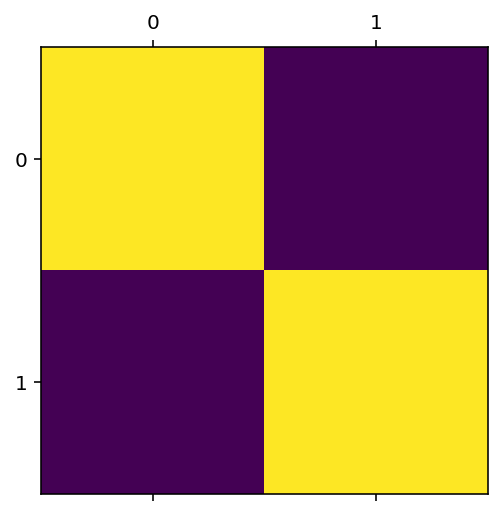

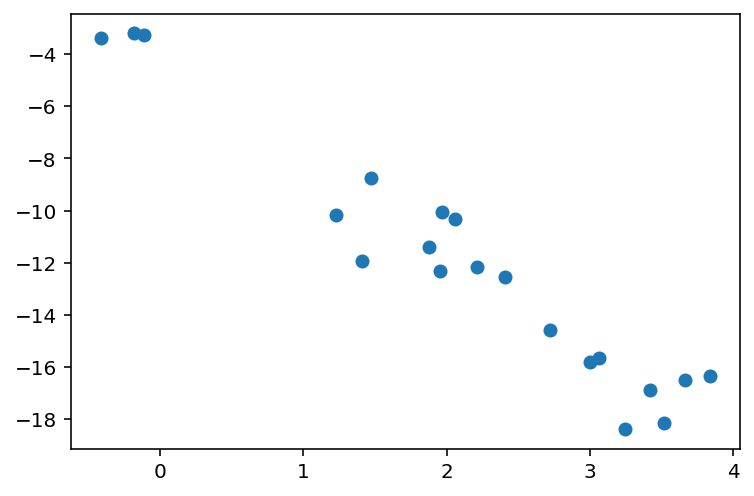

In [2]:
# We start by describing the data,
print(df1.describe())

# printing a sample of it,
print(df1.sample(5))

# looking at the correlation matrix,
corr = df1.corr()
print(corr)

# visualizing the matrix,
plt.matshow(corr)
plt.show()

# and plotting the points.
plt.scatter(df1['x'], df1['y']);

We next build our linear model using linear regression, "regressing $y$ onto $x$", print our $R^2$ score, and plot our prediction line against the data.

y-intercept: [-4.48088849]
x coefficient(s): [[-3.59487644]]
R^2 score: 0.9368679649823967
true intercept and coefficient before noise addition: [-4.04705831102925, -3.8026345019834284]


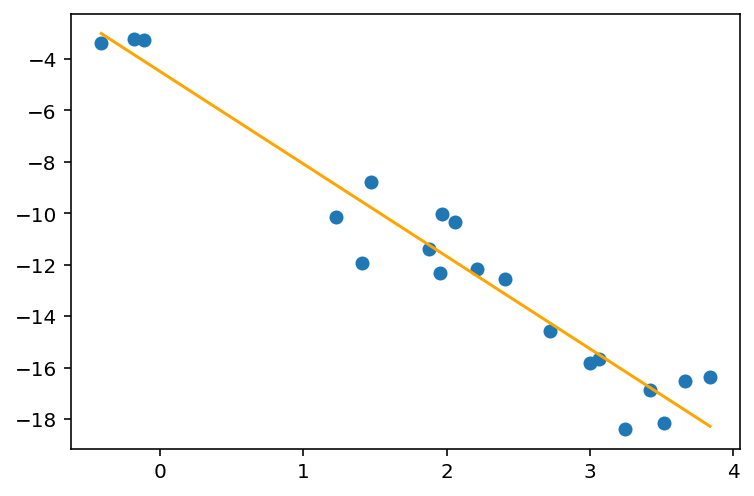

In [3]:
X = df1[['x']]  # select input(s)
y = df1[['y']]  # select output
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('x coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

# Incidentally, the true intercept and coefficient before noise addition were
print('true intercept and coefficient before noise addition:', c1)

x_vals = np.linspace(start=X.min(), stop=X.max(), num=1000)  # 1000 linearly spaces points from the min to the max of x
# (We only need the min and the max for plotting the linear fit, but the previous expression
#  will be helpful for plotting nonlinear fits.)
yfit = linear_regressor.predict(x_vals)
plt.scatter(X, y)
plt.plot(x_vals, yfit, color='orange');


## Nonlinear Regression

Sometimes we have a nonlinear relationship between input and output.  Observe that our simple exploratory data analysis for dataframe ```df2``` does not indicate a linear relationship:

                x           y
count  100.000000  100.000000
mean    -0.224314   15.661395
std      2.749698   55.663883
min     -4.953045  -44.941152
25%     -2.478430  -20.792577
50%     -0.325190    1.195412
75%      1.682173   23.925362
max      4.883738  198.704346
           x          y
34 -2.038598 -38.560945
27 -0.313488 -15.040852
41 -2.346105 -33.419104
4  -1.845716 -28.928520
95 -0.685816 -33.202390
          x         y
x  1.000000  0.723678
y  0.723678  1.000000


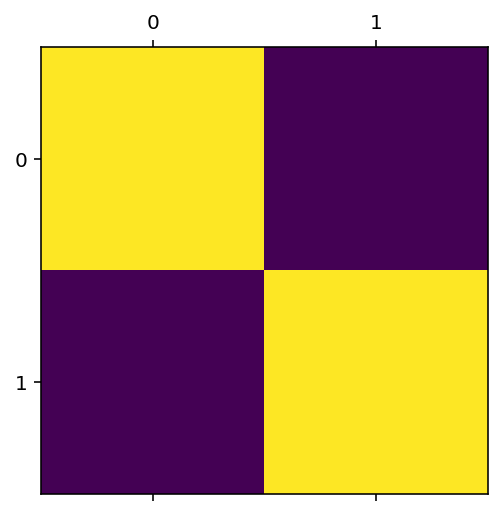

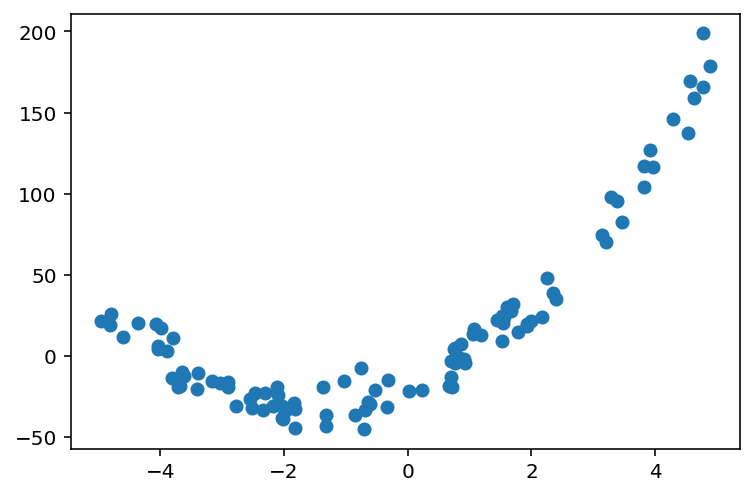

In [4]:
print(df2.describe())
print(df2.sample(5))
corr = df2.corr()
print(corr)
plt.matshow(corr)
plt.show()
plt.scatter(df2['x'], df2['y']);

This relationship looks like a [parabola](https://en.wikipedia.org/wiki/Parabola) which means our relationship is likely [quadratic](https://en.wikipedia.org/wiki/Quadratic_function), i.e. of the form $y = ax^2 + bx + c$.  How can we use linear regression to perform quadratic regression?  We can add an $x^2$ value column to our dataframe and perform linear regression as usual.

How does this work?  Suppose we had input variables $A$ and $B$ with output $y$.  Then a linear regression would compute corresponding coefficients for $A$ and $B$, which we'll call $a$ and $b$ respectively, as well as a $y$-intercept that we'll call $c$.  Then the model we build will be of the form $y = aA + bB + c$.  If you substitute $x^2$ values for $A$ and corresponding $x$ values for $B$, we can see this is of the form $y = ax^2 + bx + c$, a quadratic equation.

Adding or modifying features for modeling is called _feature engineering_.  Creating a new column with a squared term is a simple form of feature engineering.  Let's look at how this works in practice as we fit our quadratic relationship:

y-intercept: [-19.69130802]
x coefficient(s): [[15.48119693  5.1522942 ]]
R^2 score: 0.9728297386356879
true intercept and coefficients before noise addition: [-19.954287227422867, 16.086638017583308, 5.205893616458912]


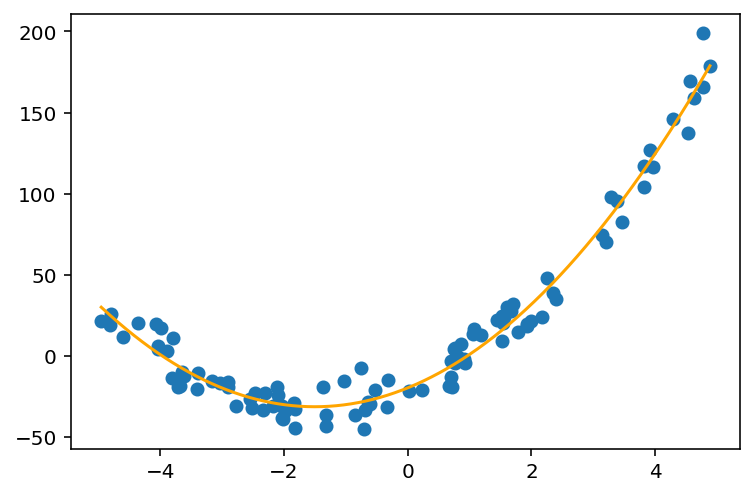

In [5]:
X = df2[['x']]  # select input(s)
X['x2'] = df2['x'].pow(2)  # add a new column 'x2' with values from column 'x' squared
y = df2[['y']]  # select output
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('x coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

# Incidentally, the true intercept and coefficient before noise addition were
print('true intercept and coefficients before noise addition:', c2)

Xfit = pd.DataFrame()
Xfit['x'] = np.linspace(start=X['x'].min(), stop=X['x'].max(), num=1000)  # 1000 linearly spaces points from the min to the max of x
Xfit['x2'] = Xfit['x'].pow(2)  # add square terms as new column 'x2'
yfit = linear_regressor.predict(Xfit)  # predict y's from the linearly spaced x and x2 data
plt.scatter(X['x'], y)  # scatter plot of original data
plt.plot(Xfit['x'], yfit, color='orange');  # line plot showing fit of learned quadratic function in orange

For this next dataframe ```df3```, we're not looking at a polynomial relationship between $x$ and $y$.  What relationship do you see?

                x           y
count  100.000000  100.000000
mean    -0.077459    2.517835
std      2.293049    3.274090
min     -3.908580    0.065685
25%     -2.047756    0.257683
50%     -0.326161    0.803129
75%      1.875823    3.492703
max      3.783356   12.460859
           x         y
39  1.565004  2.855809
64 -0.556780  0.689711
59 -1.545519  0.363020
37 -0.350875  0.795903
25 -3.283176  0.108885
          x         y
x  1.000000  0.852239
y  0.852239  1.000000


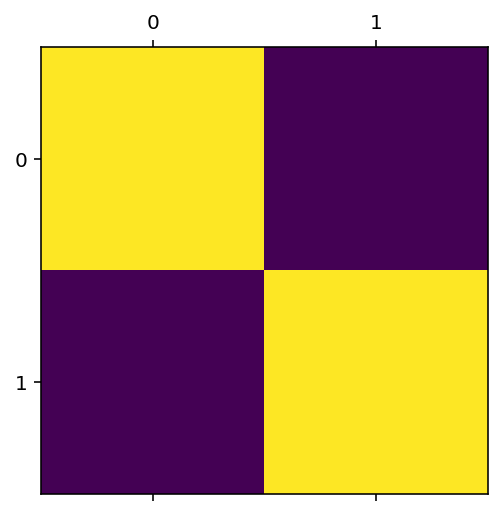

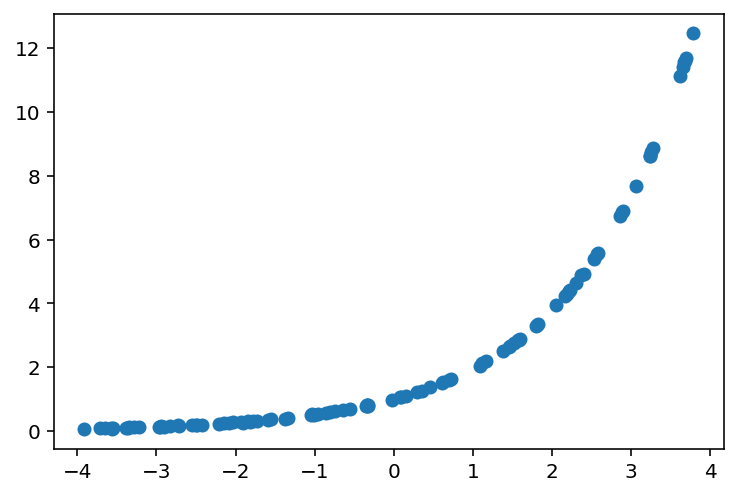

In [6]:
print(df3.describe())
print(df3.sample(5))
corr = df3.corr()
print(corr)
plt.matshow(corr)
plt.show()
plt.scatter(df3['x'], df3['y']);

This looks to be an exponential relationship of the form $y = b^x$ where $b$ is positive.  If we take the $\log_c$ of both sides $\log_c(y) = \log_c(b^x)$ for some positive $c$, the right hand side according to the [logarithm change of base rule](https://www.khanacademy.org/math/algebra2/x2ec2f6f830c9fb89:logs/x2ec2f6f830c9fb89:change-of-base/a/logarithm-change-of-base-rule-intro) is equivalent to $\frac{\log_b(b^x)}{\log_b{c}} = \frac{x}{\log_c{b}}$ which is $x$ divided by a constant factor.  In other words, taking a logorithm of the output of an exponential function, we get values with a linear relationship.  This is visually illustrated through the use of [semi-log plots](https://en.wikipedia.org/wiki/Semi-log_plot).

What does this mean to our use of linear regression for modeling an exponential relationship?  We can do one of two things:

1. Transform our $y$ outputs to $\log(y)$, regress $\log(y)$ onto $x$, predict $\log(y)$ values for which we then untransform predictions with the inverse transformation $e^{\log(y)} = y$.
2. Transform our $x$ inputs to $e^x$, regress $y$ onto $e^x$, and make predictions by first computing $e^x$ for each new input $x$.

General practice is to perform option (1) because linear regression is based on least-squares error when looking at the distances of points to the fit line.  If we're in the exponential space, this gives the large exponential values greater weight to the fit, whereas we would generally want all points to treats as having the same importance for fit.  In this case, we're engineering the output, not the feature(s), i.e. input(s).  Observe this approach:

           x         y     y_log
72 -2.502953  0.196863 -1.625248
54 -0.321153  0.800711 -0.222255
99 -2.724684  0.171072 -1.765669
17 -2.142127  0.236836 -1.440387
46  2.229563  4.418600  1.485823
y-intercept: [-0.01099079]
x coefficient(s): [[0.67344706]]
R^2 score: 0.9992346524707725


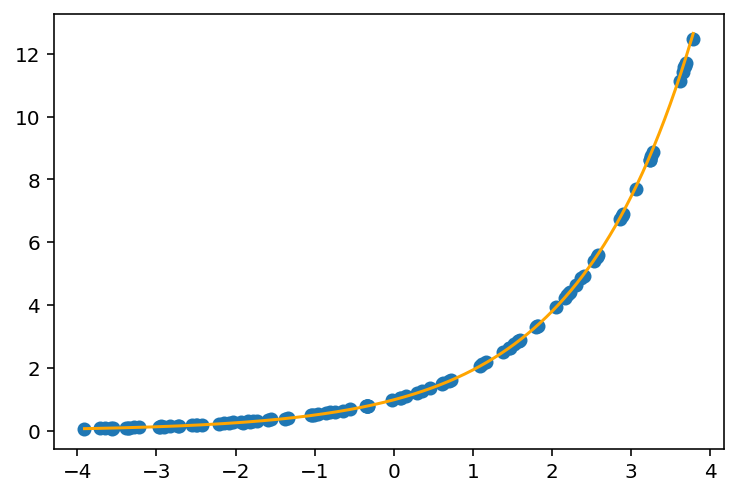

In [7]:
X = df3[['x']]  # select input(s)
df3['y_log'] = np.log(df3['y'])  # select output
print(df3.sample(5))
y = df3[['y_log']]
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('x coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

Xfit = pd.DataFrame()
Xfit['x'] = np.linspace(start=X['x'].min(), stop=X['x'].max(), num=1000)  # 1000 linearly spaces points from the min to the max of x
yfit = np.exp(linear_regressor.predict(Xfit))  # predict y's from the linearly spaced x data
plt.scatter(X['x'], df3['y'])  # scatter plot of original data
plt.plot(Xfit['x'], yfit, color='orange');  # line plot showing fit of learned quadratic function

The main lesson here is that nonlinear relationships can be predicted using linear regression if one
* discerns the type of nonlinear relationships between the variables,
* transforms inputs and/or outputs so as to mathematically arrive at a linear relationship between transformed variables,
* performs a linear regression with the transformed data, and
* uses pre- and/or post-processing of data before and/or after application of the linear model in order to predict non-linear relationships.

**To-Do:** For practice before class, create a cell below and use linear regression to predict a nonlinear cubic relationship in dataframe ```df4``` similar to the quadratic example above but, in this case, you'll need to create and regress onto additional new columns ```x2``` and ```x3``` you will create that that contain $x^2$ and $x^3$, respectively.

## Multiple Regression

_Multiple regression_ refers to cases where we are regressing our output onto multiple input variables.  We have already been performing multiple linear regressions when we were introduced to Kaggle and in our Kaggle competition "signal and noise" homework.  In the previous pre-class exercise, we engineered additional polynomial term features $x^2$ and $x^3$ so as to be able to use these multiple inputs to model a cubic relationship between $y$ and the original sole input $x$.

However we may have more complex multiple regressions.  Dataframe ```df5``` has two inputs ```x1``` and ```x2```, but the relationship between them and ```y``` is more complex:

               x1          x2           y
count  500.000000  500.000000  500.000000
mean     0.101295    0.107199  204.766554
std      2.966905    2.968324  163.064938
min     -4.993358   -4.996327  -12.949604
25%     -2.428176   -2.364742   71.324889
50%     -0.065073    0.066029  163.980418
75%      2.731473    2.820355  327.454902
max      4.998086    4.983549  738.683307
           x1        x2           y
407 -1.420161 -0.648580   29.703968
24  -0.916971 -1.225934   16.301406
275  1.775084  4.378644  192.994450
237 -2.963791  0.663116  154.616233
98  -2.823372  4.738187  150.076473
          x1       x2         y
x1  1.000000  0.05927  0.076864
x2  0.059270  1.00000  0.008370
y   0.076864  0.00837  1.000000


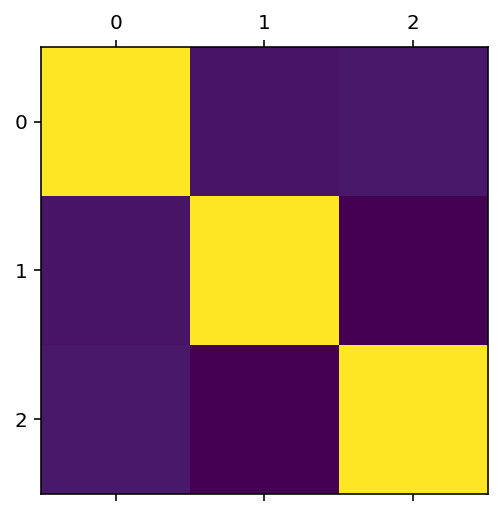

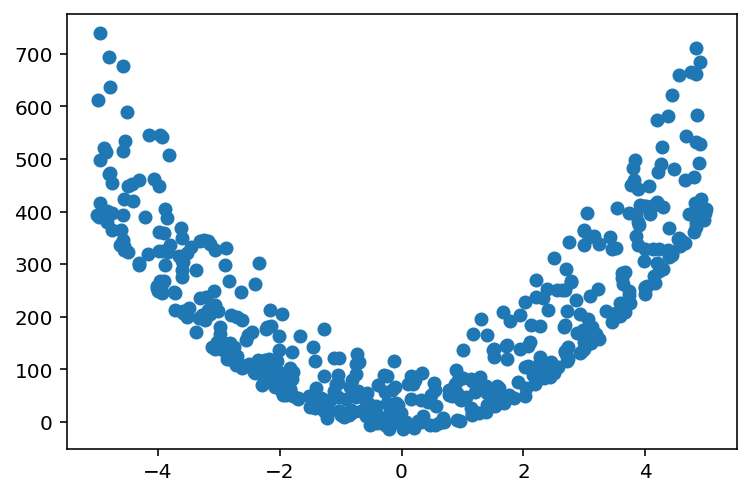

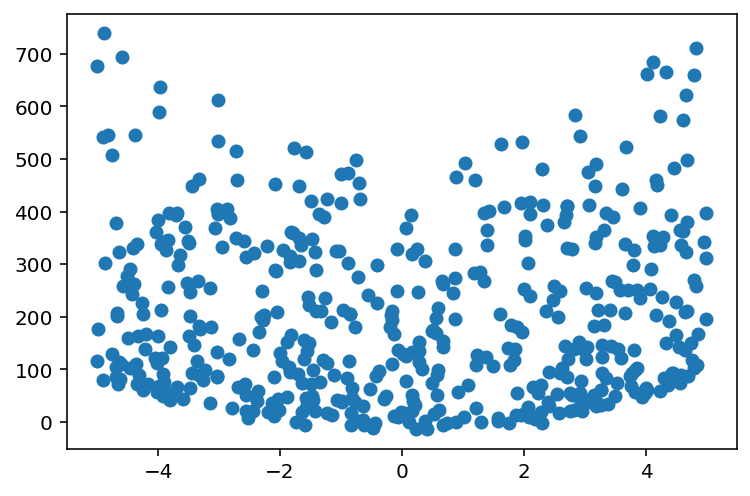

In [9]:
print(df5.describe())
print(df5.sample(5))
corr = df5.corr()
print(corr)
plt.matshow(corr)
plt.show()
plt.scatter(df5['x1'], df5['y']);
plt.show()
plt.scatter(df5['x2'], df5['y']);
plt.show()

It's a more complex relationship we're looking at here.  We can see what looks like a parabola in the first ```x1```-```y``` scatter plot.  The ```x2```-```y``` scatter plot relationship is less clear.  Sometimes, 3D visualization helps:

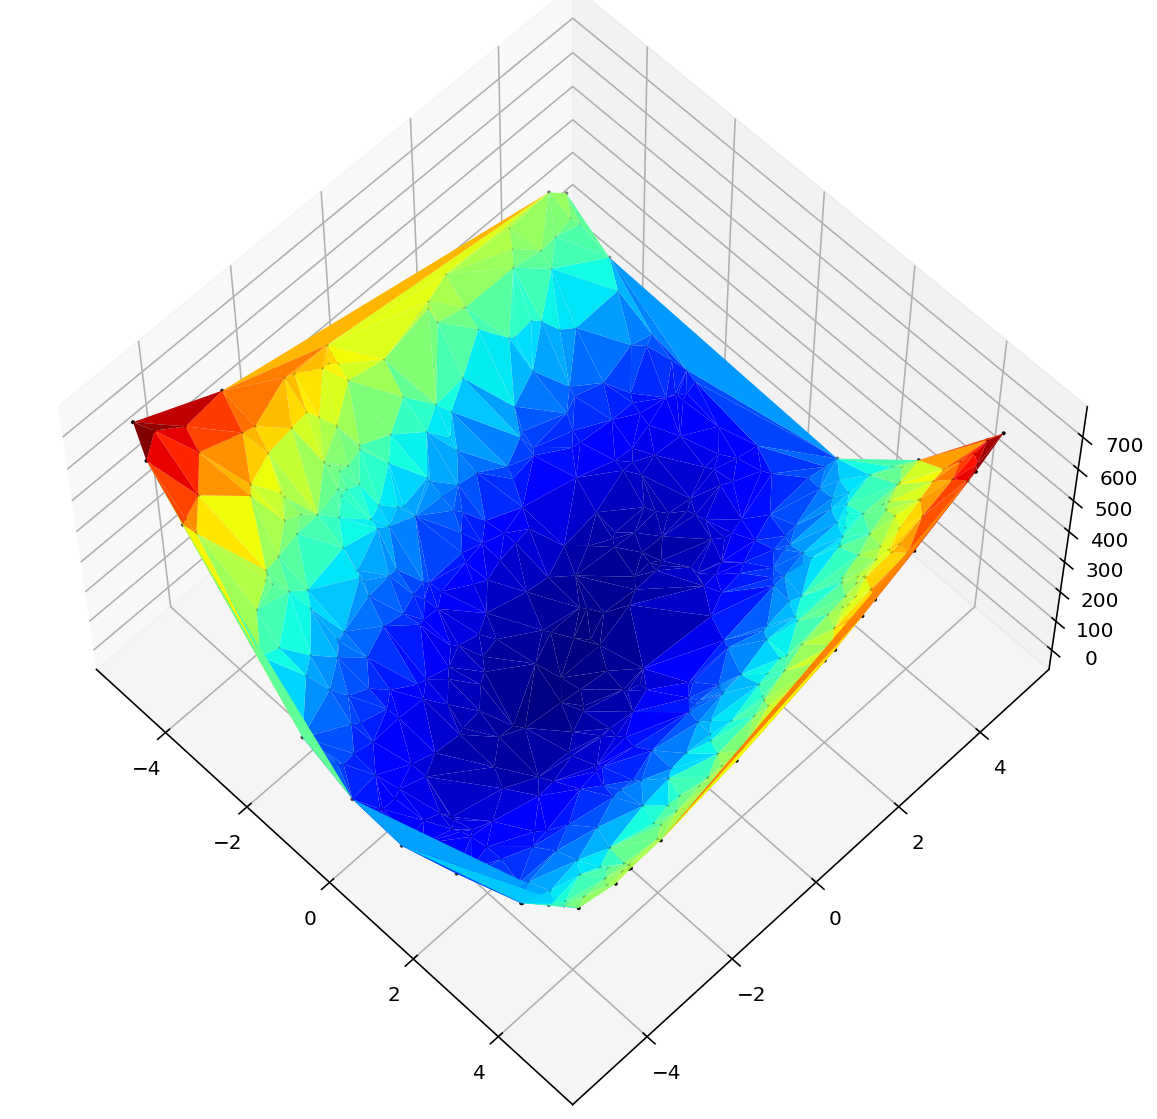

In [10]:
plt.figure(figsize=(10,10))  # set the figure size
ax = plt.gca(projection='3d')  # Initialize...
ax.view_init(elev=60, azim=-45)  # set the elevation and the azimuth (angles up-down, left-right) of the view
ax.scatter3D(df5['x1'], df5['x2'], df5['y'], s=1, c='black');  # x1-x2-y 3D scatterplot with size 1 dots and grayscale coloring
triang = mtri.Triangulation(df5['x1'], df5['x2'])  # create a triangular mesh between the irregular (i.e. non-grid-mesh) x1, x2 points
ax.plot_trisurf(triang, df5['y'], cmap='jet')  # rainbow-colored ("jet") surface plot of triangular mesh
plt.show()

Here we see a somewhat bowl-like shape where the mesh coloration highlights that the values toward $(4, 4)$ and $(-4, -4)$ are higher valued for $y$ than those near $(4, -4)$ and $(-4, 4)$.  This can indicate that our model should include an _interaction term_ between ```x1``` and ```x2```, i.e. an ```x1 * x2``` term.

Seeing the parabolic curving and noting the corner skew here, we will add such squared and interaction terms to our dataframe and see what the correlations with ```y``` tell us:

In [11]:
df5['x1sqr'] = df5['x1'].pow(2)
df5['x2sqr'] = df5['x2'].pow(2)
df5['x1x2'] = df5['x1']*df5['x2']
print(df5.sample(5))
corr = df5.corr()
print(corr)

           x1        x2           y      x1sqr      x2sqr       x1x2
176  0.189899 -4.339257   71.376229   0.036062  18.829154  -0.824022
311 -4.162086  0.161237  320.049529  17.322964   0.025997  -0.671082
214  1.646656 -0.769456   38.045357   2.711476   0.592062  -1.267029
369 -1.405468  4.003675   63.969374   1.975342  16.029410  -5.627038
67  -3.584935  3.659455  206.869872  12.851760  13.391609 -13.118908
             x1        x2         y     x1sqr     x2sqr      x1x2
x1     1.000000  0.059270  0.076864  0.069997  0.082723 -0.007241
x2     0.059270  1.000000  0.008370 -0.048182  0.048493  0.101870
y      0.076864  0.008370  1.000000  0.892842  0.222547  0.387578
x1sqr  0.069997 -0.048182  0.892842  1.000000  0.017380 -0.011793
x2sqr  0.082723  0.048493  0.222547  0.017380  1.000000 -0.003311
x1x2  -0.007241  0.101870  0.387578 -0.011793 -0.003311  1.000000


From the sample, we do a visual check that our feature engineering is as we expect.

Now look at the ```y``` column in the correlation matrix.  Of the inputs, ```x1``` and ```x2``` have the weakest (smallest magnitude) correlations with ```y```.  Let's perform our multiple regression with and without them:

In [12]:
X = df5[['x1', 'x2', 'x1sqr', 'x2sqr', 'x1x2']]  # select input(s)
y = df5[['y']]  # select output
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('X coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

y-intercept: [-8.70994056]
X coefficient(s): [[-5.41731680e-03  4.00088872e-02  1.92893114e+01  4.53299684e+00
   7.34810381e+00]]
R^2 score: 0.9990676061538825


We note that this is a very good $R^2$ score, yet the ```x1``` and ```x2``` coefficients are small.  This in and of itself is not indicative of irrelevance.  It could be that the values are very large and contribute significantly even scaled down significantly.  That is not the case here.  Let's see what happens when we eliminate ```x1``` and ```x2``` from our multiple regression:

In [13]:
X = df5[['x1sqr', 'x2sqr', 'x1x2']]  # select input(s)
y = df5[['y']]  # select output
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('X coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

y-intercept: [-8.70442637]
X coefficient(s): [[19.28841374  4.53360907  7.34947688]]
R^2 score: 0.9990670826268384


The $R^2$ score is almost exactly the same.  The difference is negligible, but it is slightly lower without the ```x1``` and ```x2``` terms.  Does that mean that they were helpful after all?

The answer, as we shall better understand in a future class, is _no_.   This is why, as we see on Kaggle, that we typically separate data into training and testing sets.  A model will use all training information given to fit and _perhaps overfit_ the data, crafting a model to minimize error of prediction for that data, but one could see worse generalization of the model to other unseen cases for having included irrelevant terms and used them to fit.

The $y$ values were indeed generated with $x1^2$, $x2^2$, and $x1 x2$, but without $x1$ and $x2$.  In the future when studying _validation_, we'll see how the "less is more" adage applies to modeling that generalizes better beyond the training dataset.

One last example of a technique that can be helpful in discerning relationships between variables is that of _pair plots_.  Like a correlation matrix, we have a grid of indicators for each pair of variables.  However each of the grid cells is, by default, a scatterplot to give us a visual overview of pair relationships.   For this, we'll use the ```seaborn``` visualization library to visually inspect dataframe ```df6```.

               x1          x2          x3          x4          x5           y
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000
mean    -0.113264   -0.108520    0.030768   -0.097809   -0.143990   12.499032
std      2.806599    2.923620    2.747174    2.925213    2.865771   55.641361
min     -4.982622   -4.999276   -4.949481   -4.964893   -4.981805  -88.829290
25%     -2.553194   -2.631763   -2.134008   -2.594103   -2.614885  -33.867854
50%     -0.044843   -0.069502   -0.010031   -0.323283   -0.074085   13.127945
75%      2.311194    2.433680    2.384615    2.551153    2.204551   60.279181
max      4.934052    4.999490    4.958300    4.999311    4.999640  141.951461
           x1        x2        x3        x4        x5           y
468 -1.831574  1.760678 -1.048063 -0.515951  3.561792   -9.553707
323 -1.209319 -3.858487  0.618129  1.415937  4.870915   29.685263
411 -0.615233 -2.230544  4.528195  3.022408  0.863030  104.275111
386  0.454002 -4.183287 -0.531403 

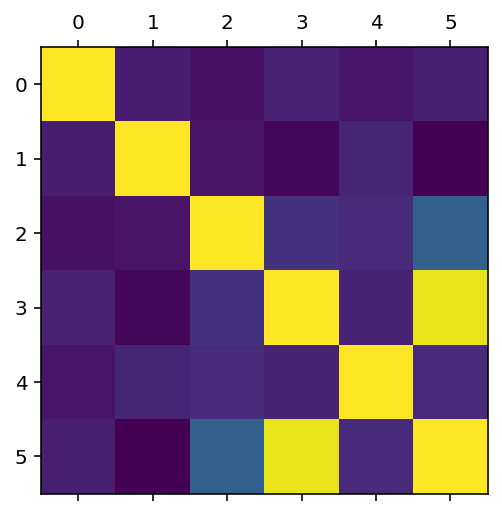

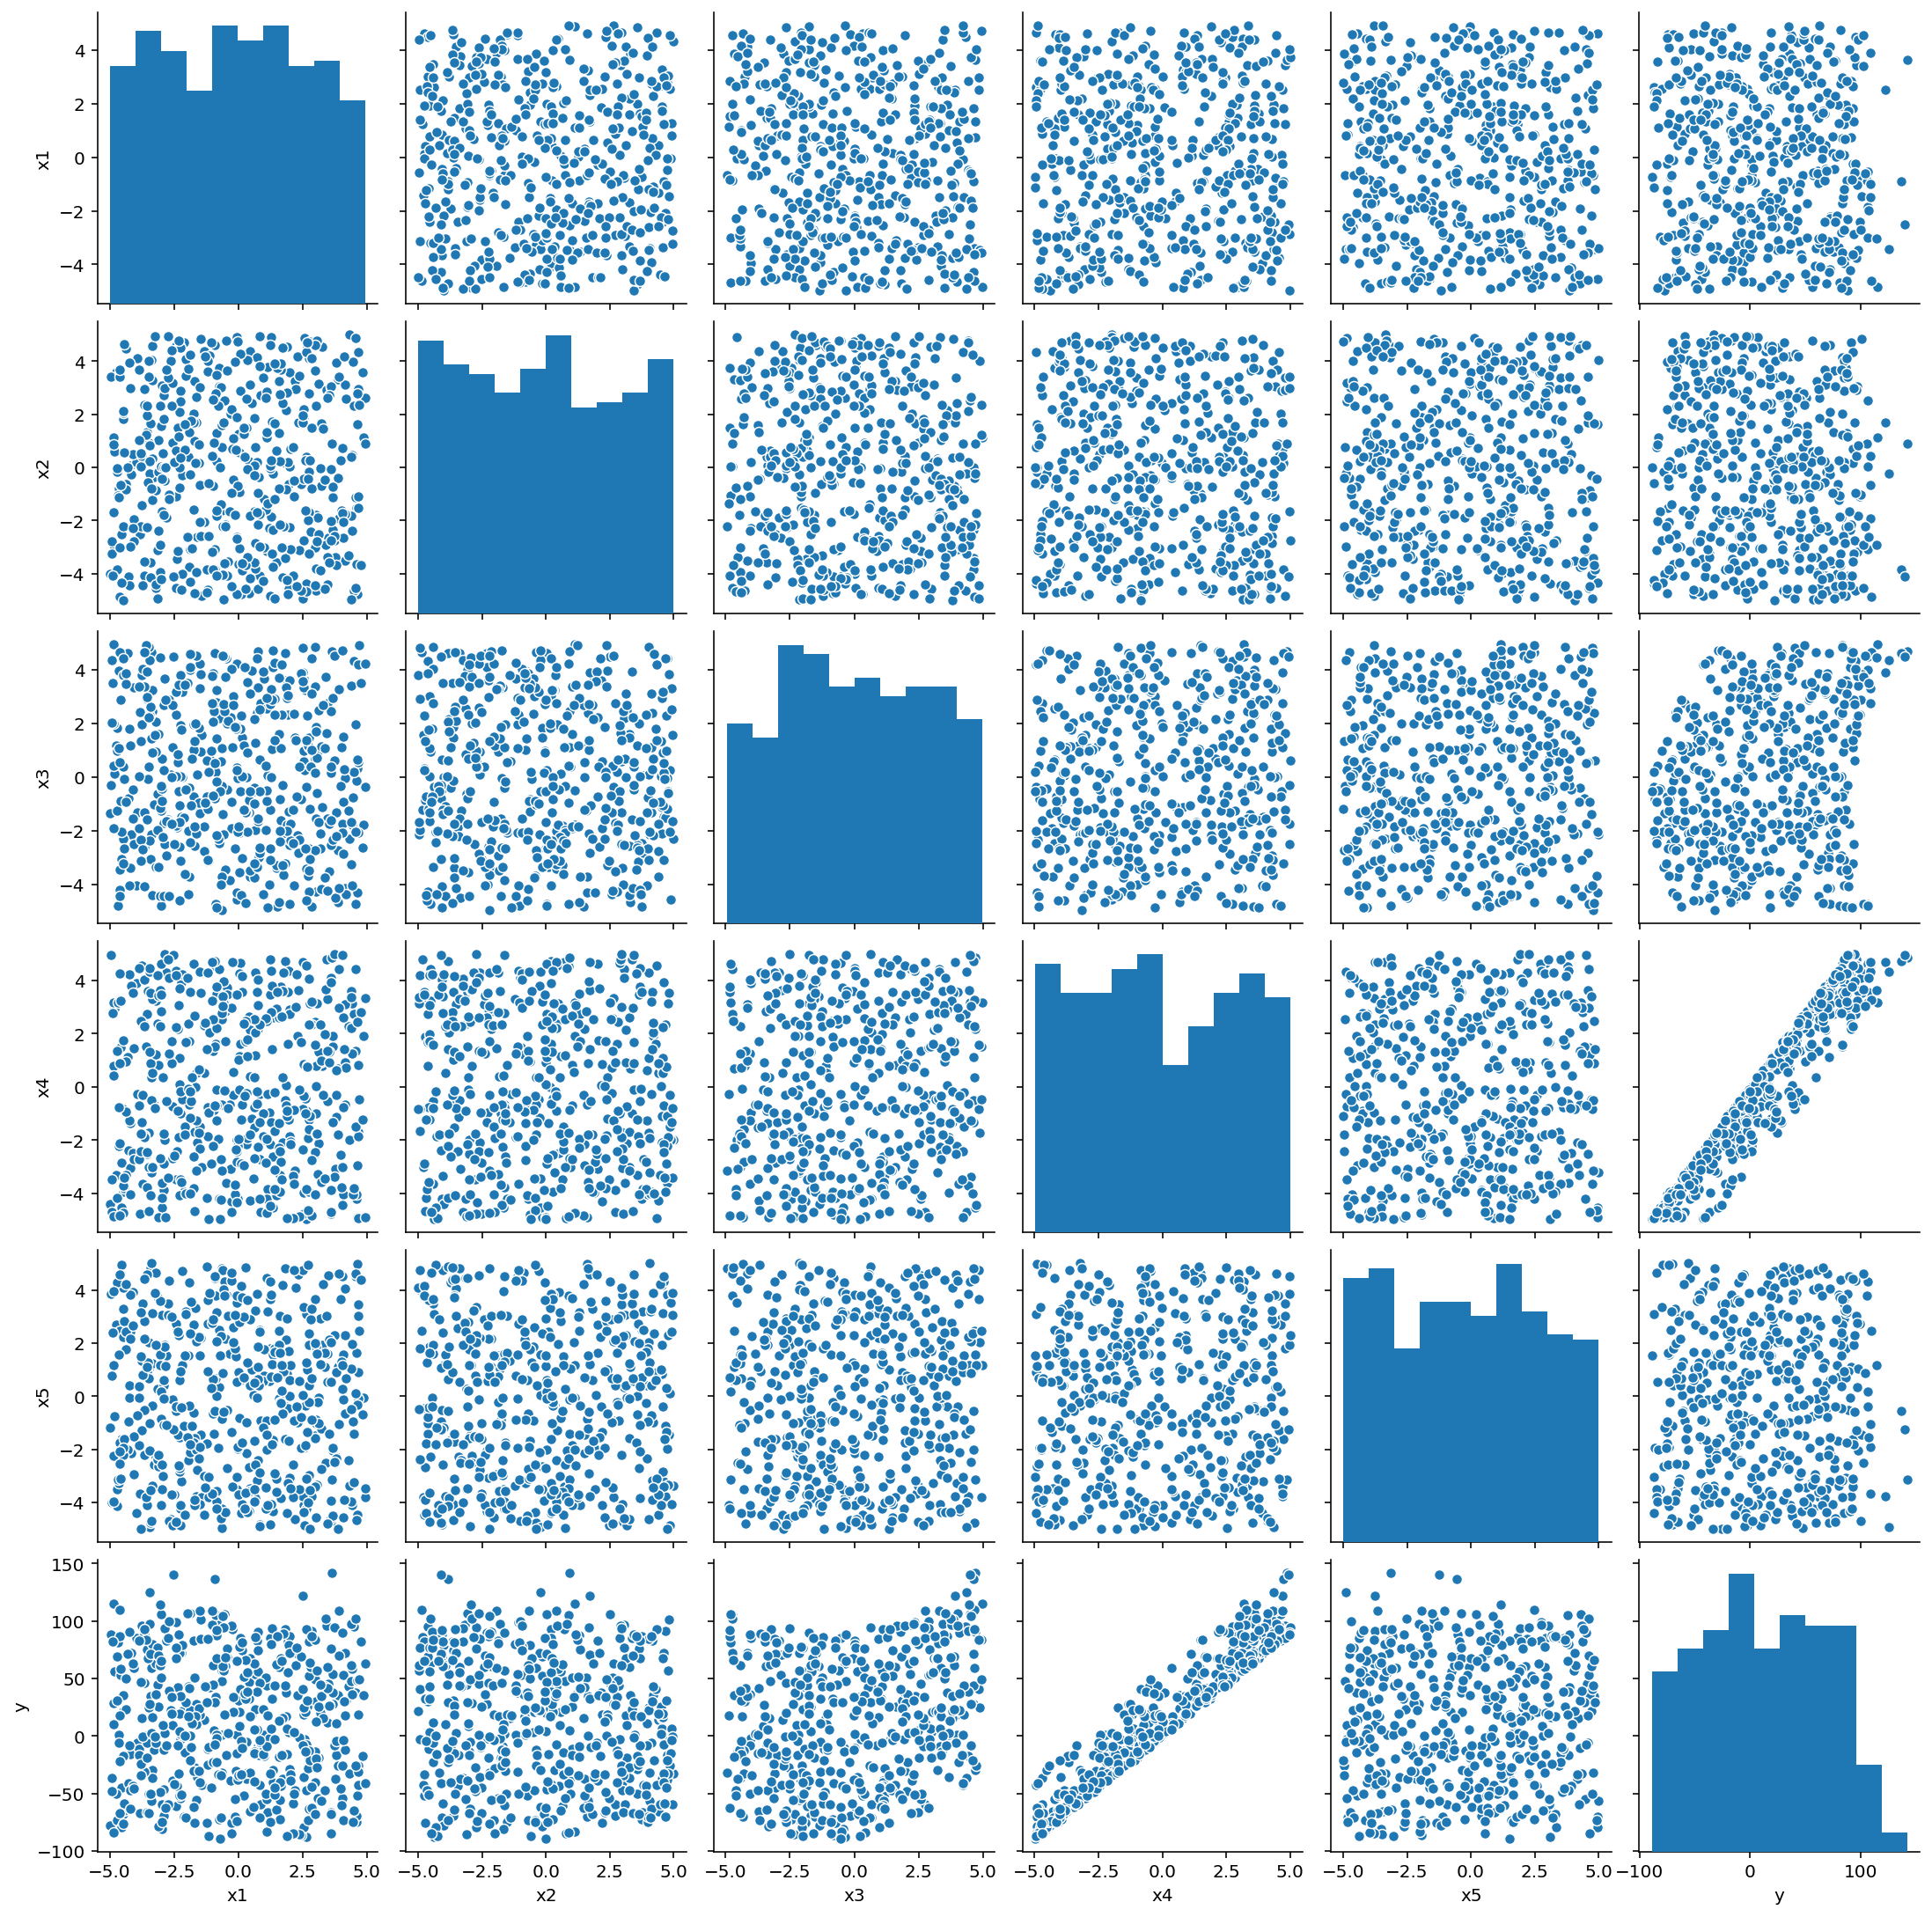

In [14]:
print(df6.describe())
print(df6.sample(5))
corr = df6.corr()
print(corr)
plt.matshow(corr)
plt.show()

sns.pairplot(df6)  # create a seaborn pair plot
plt.show()

Along the diagonals, we see histograms of each variable's distribution.  We also see that there's a clear linear relationship between ```x4``` and ```y```, but note the second-highest correlation variable, ```x3```.  Whereas there's what appears to be random noise in other grid cells (and low correlation), there's something ordered to the mass of points in the ```x3```-```y``` scatter plot.  This could indicate a squared relationship.  Let's test that.

Note: Seaborn pair plots are computationally intensive and take up memory.  Feel free to comment out your pair plot lines (putting a "#" at the front of those lines) in order to improve the performance of your notebook.

             x1        x2        x3        x4        x5         y     x3sqr
x1     1.000000 -0.016763 -0.051027 -0.000053 -0.038099 -0.008030  0.010361
x2    -0.016763  1.000000 -0.042748 -0.082674  0.009891 -0.102259 -0.084237
x3    -0.051027 -0.042748  1.000000  0.058973  0.033272  0.234162  0.070038
x4    -0.000053 -0.082674  0.058973  1.000000  0.008657  0.962233  0.035776
x5    -0.038099  0.009891  0.033272  0.008657  1.000000  0.028191  0.076527
y     -0.008030 -0.102259  0.234162  0.962233  0.028191  1.000000  0.251343
x3sqr  0.010361 -0.084237  0.070038  0.035776  0.076527  0.251343  1.000000


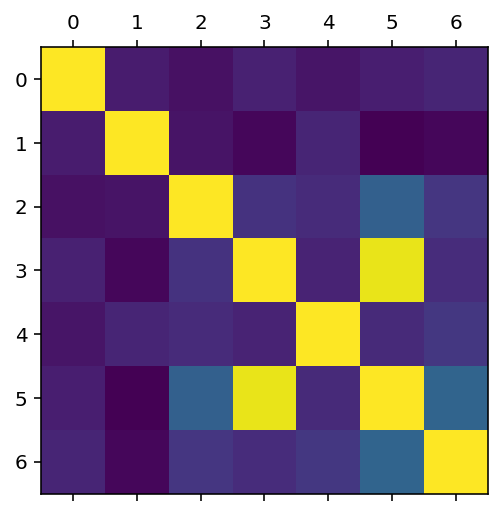

In [15]:
df6['x3sqr'] = df6['x3'].pow(2)
corr = df6.corr()
print(corr)
plt.matshow(corr)
plt.show()

#sns.pairplot(df6)  # create a seaborn pair plot

While the parabola may stick out to you at first, that's just the relationship we engineered by adding the square term.  Instead, focus on the boundaries of the ```x3sqr```-```y``` plot.  There's a definite slant to them.  Looking at the correlations, we see that ```x3sqr``` has an even higher correlation to ```y``` than ```x3```.  One approach to modeling is to start with the highest correlating term and incrementally add the next highest and so on until we see no significant increase in error measures (like $R^2$).  Let's try that and see what occurs:

**```x4``` only:**

In [16]:
X = df6[['x4']]  # select input(s)
y = df6[['y']]  # select output
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('X coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

y-intercept: [14.28922864]
X coefficient(s): [[18.30293335]]
R^2 score: 0.9258929319042501


**```x4``` and ```x3sqr```**:

In [17]:
X = df6[['x4', 'x3sqr']]  # select input(s)
y = df6[['y']]  # select output
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('X coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

y-intercept: [1.39654581]
X coefficient(s): [[18.15513056  1.70961572]]
R^2 score: 0.9730069480013654


Our $R^2$ score shows clear improvement.  Input ```x3sqr``` was a good addition.

**```x4```, ```x3sqr```, and ```x3```:**

In [18]:
X = df6[['x4', 'x3sqr', 'x3']]  # select input(s)
y = df6[['y']]  # select output
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('X coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

y-intercept: [1.93845045]
X coefficient(s): [[17.9787672   1.62182017  3.32146742]]
R^2 score: 0.9996820274052338


This shows another clear improvement.  Now let's look at our next highest correlator ```x5```, which has an order of magnitude lesser correlation than ```x3```.

**```x4```, ```x3sqr```, ```x3```, and ```x5```:**

In [19]:
X = df6[['x4', 'x3sqr', 'x3', 'x5']]  # select input(s)
y = df6[['y']]  # select output
linear_regressor = LinearRegression()  # create linear regression object
linear_regressor.fit(X, y)  # perform linear regression of output onto inputs
print('y-intercept:', linear_regressor.intercept_)  # print the y-intercept
print('X coefficient(s):', linear_regressor.coef_)  # print the x coefficient
print('R^2 score:', linear_regressor.score(X, y))  # print R^2 score

y-intercept: [1.92961547]
X coefficient(s): [[17.9788686   1.62253724  3.32215671 -0.02376627]]
R^2 score: 0.9996835157652755


This is _not_ a significant improvement, so we would tend to prefer the simpler model with ```x4```, ```x3sqr```, and ```x3```.  Indeed, these were the only variables used for generating the data.

# In Class

Together in class, you will seek to build models for each of the given data sets using the techniques above.

In the cell below, build a model to predict ```y``` given dataframe ```df7```.  Perform a pair plot before modeling.  Perform an $R^2$ test and plot your model fit using an appropriate visualization method from above.

For the next in-class exercise, you'll load your data from this [data8.csv](http://cs.gettysburg.edu/~tneller/ds256/data/inclass/data8.csv) file, which you can and should load directly using the URL [http://cs.gettysburg.edu/~tneller/ds256/data/inclass/data8.csv](http://cs.gettysburg.edu/~tneller/ds256/data/inclass/data8.csv) using the method we saw in the first class demonstration.  Not all inputs will be relevant to predicting the output ```y```.  Use the correlation matrix, its graphical representation, and seaborn pair plots to discern the relevant inputs.  Then build a model with those inputs, print which inputs you are using, the y-intercept, the input coefficients, and the $R^2$ score.

Next, build a model for ```y``` using data from the URL [http://cs.gettysburg.edu/~tneller/ds256/data/inclass/data9.csv](http://cs.gettysburg.edu/~tneller/ds256/data/inclass/data9.csv).  The relationship here is more complex, so I recommend adding squared terms for each input and interaction terms for each pair of inputs.  Having added all of these engineered features to your dataframe, compute the correlation matrix and look at the correlations with ```y```.  Build your first model for ```y``` with the highest correlating input and check the $R^2$ score.  Then add the next highest  correlating input and compare the resulting $R^2$ with the previous one.  When you don't see significant improvement, return to the previous model and print out the y-intercept and coeefficients for your input terms.

In you have time remaining, here are some options for further in-class practice:
* Following the forms used at the beginning of this document, create data with similarly obscured models for each other to practice discerning the best model.
* Practice some of the visualization techniques with the data from in-class exercises, e.g. the curve fit for the first in-class problem or a 3D plot of the surface for the last problem.

## Homework

**Exercise 1:** In the code cell below this:
* Read CSV data into a dataframe from [http://cs.gettysburg.edu/~tneller/ds256/data/hw6/hw6-1.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw6/hw6-1.csv).
* Print a description of the data and a sample of 5 rows.
* Scatter plot the data.
* Note the [polynomial](https://en.wikipedia.org/wiki/Polynomial) relationship between input ```x``` and output ```y```.  Add polynomial term inputs for the likely [polynomial](https://en.wikipedia.org/wiki/Polynomial).
* Perform a nonlinear regression using linear regression with these (mostly nonlinear) polynomial input terms.
* Print the y-intercept, coefficients, and $R^2$ score of your model.
* Scatter plot the data again along with an orange fit curve to demonstrate your linear regression model fit.

**Exercise 2:**  In the next code cell,
* Create a dataframe with the CSV data loaded directly from [http://cs.gettysburg.edu/~tneller/ds256/data/hw6/hw6-2.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw6/hw6-2.csv).
* Print a description and a size 5 sample of it.
* Print a correlation matrix and plot the color-coded representation of the correlation matrix.
* Print seaborn pair plots of the dataframe.
* Build a model of ```y``` using the relevant, correlating subset of the input data.
* Print the y-intercept, the input term coefficients, and the $R^2$ score.

**Exercise 3:**  In the next code cell,
* Create a dataframe with the CSV data loaded directly from [http://cs.gettysburg.edu/~tneller/ds256/data/hw6/hw6-3.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw6/hw6-3.csv).
* Print a description and a size 5 sample of it.
* Print a correlation matrix and plot the color-coded representation of the correlation matrix.  (Relationships will not be clear yet.)
* Graph irregular 3D surface plots for each pair of inputs with the output to look for higher order relationships  In other words, create 3D plots for the (x1, x2, y) surface, the (x1, x3, y) surface, and the (x2, x3, y) surface.  You will find that two are noisy evidenced by many spikes, and one is a well-known [paraboloid](https://en.wikipedia.org/wiki/Paraboloid) whose smooth surface is evident.
* Add appropriate squared input terms to the dataframe to model that paraboloid.
* Compute and print the new correlation matrix to verify the high correlation of added squared input terms.
* Build a model of ```y``` using the relevant, highly-correlating subset of the input terms.
* Print the terms used, the y-intercept, the input term coefficients, and the $R^2$ score.

(end of homework)